2019-10-16

### Workflow

* Classification: This is a binary classification problem in which we identify and classify whether a member will purchase miles or not after the marketing campaign.
* Correlation: We can approach the problem based on available features within the training data. Which features contribute significantly to the target? Or is there a correlation between a feature and the target? In addition, we also want to determine correlation between independent features for multicollinearity check.
* Preparation: This includes converting data types, determining how to deal with missing values, creating new features and so on. 
* EDA: Using the right visualization plots.

In [1]:
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

pd.set_option('display.max_columns', 100)

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('Training Data Set.csv')

In [3]:
df_train.tail(5)

,balance,tier,aag_yr1,cardholder,email_subscriber,enrollment_date,nonflt_use,awd_use,most_recent_flt,most_recent_awd,flt_segs_12mo,flt_segs_6mo,flt_segs_3mo,nonflt_earn_12mo,nonflt_earn_6mo,nonflt_earn_3mo,lifetime_aag_base_miles,affinity_spend_12mo,affinity_spend_6mo,affinity_spend_3mo,flt_base_12mo,flt_base_6mo,flt_base_3mo,flt_promo_12mo,flt_promo_6mo,flt_promo_3mo,ptnr_miles_earned_12mo,ptnr_miles_earned_6mo,ptnr_miles_earned_3mo,ptnr_miles_redeemed_12mo,ptnr_miles_redeemed_6mo,ptnr_miles_redeemed_3mo,partner_offer_opt_in,estatement_opt_in,target,ID
499920,2887080,Silver,0.0,True,True,2002-08-26T04:00:00.000Z,0,0,2016-12-22 00:00:00,2018-02-13 00:00:00,0,0,0,492283,297294,95599,47937,4892.80,2965.09,948.14,0,0,0,0,0,0,492283,297294,95599,0,0,0,False,True,0,349162
499921,3049968,Platinum,80386.0,True,True,1983-11-15T05:00:00.000Z,722,490000,2019-05-08 00:00:00,2019-04-23 00:00:00,57,24,10,381511,220862,64070,1005237,2746.04,1511.58,521.65,47434,20390,8433,80069,34230,13196,331510,170861,64069,390000,340000,200000,True,True,0,560363
499922,3219710,Platinum,69052.0,True,True,1993-08-17T04:00:00.000Z,0,0,2019-05-10 00:00:00,2015-08-31 00:00:00,34,18,5,149463,99716,24701,727692,1455.41,964.44,245.51,47561,19040,8527,102463,38536,17357,187735,97344,24701,0,0,0,True,True,0,531021
499923,4211165,Regular,3872.0,True,True,1993-03-31T05:00:00.000Z,0,505000,2018-03-27 00:00:00,2019-03-22 00:00:00,0,0,0,166809,48760,24057,32034,1666.55,486.28,239.69,0,0,0,0,0,0,166809,48760,24057,0,0,0,True,True,0,575985
499924,6202340,Gold,55561.0,True,True,1984-09-12T04:00:00.000Z,0,0,2019-05-06 00:00:00,2009-08-29 00:00:00,68,29,17,243250,116941,80472,1226412,1856.72,938.01,657.84,38534,14369,9499,69588,30800,18761,235749,114440,80472,0,0,0,True,True,0,64434


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499925 entries, 0 to 499924
Data columns (total 36 columns):
balance                     499925 non-null int64
tier                        499925 non-null object
aag_yr1                     499918 non-null float64
cardholder                  499925 non-null bool
email_subscriber            499925 non-null bool
enrollment_date             499925 non-null object
nonflt_use                  499925 non-null int64
awd_use                     499925 non-null int64
most_recent_flt             355490 non-null object
most_recent_awd             149463 non-null object
flt_segs_12mo               499925 non-null int64
flt_segs_6mo                499925 non-null int64
flt_segs_3mo                499925 non-null int64
nonflt_earn_12mo            499925 non-null int64
nonflt_earn_6mo             499925 non-null int64
nonflt_earn_3mo             499925 non-null int64
lifetime_aag_base_miles     499925 non-null int64
affinity_spend_12mo         499925 

### Data Preprocessing & preparation

In [5]:
# Drop the column if there is only one unique value
for col in df_train:
    if df_train[col].nunique()==1:
        df_train.drop(col,inplace=True,axis=1)

Bases on the assumption that missing "most recent_flt" and "most_recent_aws" are the dates that have not come yet. So, fill missing "most_recent_flt" and "most_recent_awd" with today's date.

Fill the missing "aag_yr1" with zero. There are only a handful of them.

In [6]:
df_train['most_recent_flt'].fillna('2019-10-16', inplace=True)
df_train['most_recent_awd'].fillna('2019-10-16', inplace=True)
df_train['aag_yr1'].fillna(0, inplace=True)

Covert three date columns to date time data type, and keep date only, then calculate number of days between dates before eventaully drop these date columns.

In [7]:
for i in ['enrollment_date', 'most_recent_flt', 'most_recent_awd']:
    df_train[i] = pd.to_datetime(df_train[i])
df_train['enrollment_date'] = df_train['enrollment_date'].dt.date
df_train['most_recent_flt'] = df_train['most_recent_flt'].dt.date
df_train['most_recent_awd'] = df_train['most_recent_awd'].dt.date

for i in ['enrollment_date', 'most_recent_flt', 'most_recent_awd']:
    df_train[i] = pd.to_datetime(df_train[i])
    
df_train['days_flt_enrollment'] = (df_train['most_recent_flt'] - df_train['enrollment_date']).dt.days
df_train['days_awd_flt'] = (df_train['most_recent_awd'] - df_train['most_recent_flt']).dt.days

print(f">> First enrollment day in training data {df_train.enrollment_date.min()}")
print(f">> Last enrollment day in training data {df_train.enrollment_date.max()}")
print()
print(f">> First most recent flight date in training data {df_train.most_recent_flt.min()}")
print(f">> Last most recent flight date in training data {df_train.most_recent_flt.max()}")
print()
print(f">> First most recent award date in training data {df_train.most_recent_awd.min()}")
print(f">> Last most recent award date in training data {df_train.most_recent_awd.max()}")

df_train.drop(['enrollment_date', 'most_recent_flt', 'most_recent_awd'], axis=1, inplace=True)

>> First enrollment day in training data 1913-01-11 00:00:00
>> Last enrollment day in training data 2019-04-30 00:00:00

>> First most recent flight date in training data 2004-02-24 00:00:00
>> Last most recent flight date in training data 2019-10-16 00:00:00

>> First most recent award date in training data 2004-12-08 00:00:00
>> Last most recent award date in training data 2019-10-16 00:00:00


### Explore target feature

Our target are imbalanced, and the ratio of non-purchase to purchase instances is 99.85: 0.15. Before we go ahead to balance the classes, Let's do some more exploration.

In [8]:
df_train['target'].value_counts()

0    499175
1       750
Name: target, dtype: int64

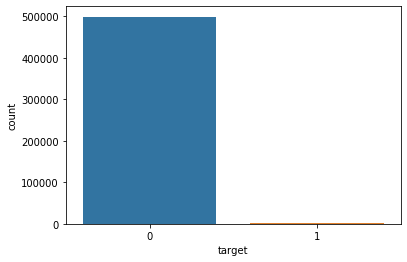

In [10]:
sns.countplot(x = 'target', data=df_train)
plt.show();

In [11]:
count_no_pur = len(df_train[df_train['target']==0])
count_pur = len(df_train[df_train['target']==1])
pct_of_no_pur = count_no_pur/(count_no_pur+count_pur)
print("Percentage of members that did not purchase is", pct_of_no_pur*100)
pct_of_pur = count_pur/(count_no_pur+count_pur)
print("Percentage members that did purchase is", pct_of_pur*100)

Percentage of members that did not purchase is 99.8499774966245
Percentage members that did purchase is 0.15002250337550632


We also add to our assumptions based on the analysis so far.

* Members who are loyal are more likely to be influenced by marketing campaigns.
* Members who are email subscribers and/or card holders are more likely to be influenced by marketing campaigns.
* Members who have a lot of balance but just a little bit short for a desired vacation are more likely to be influenced by marketing campaigns.
* Members who are active, incented to collect and redeem points are more likely to be influenced by marketing campaigns.

In [12]:
df_train.drop('ID', axis=1).groupby('target').mean()

,balance,aag_yr1,cardholder,email_subscriber,nonflt_use,awd_use,flt_segs_12mo,flt_segs_6mo,flt_segs_3mo,nonflt_earn_12mo,nonflt_earn_6mo,nonflt_earn_3mo,lifetime_aag_base_miles,affinity_spend_12mo,affinity_spend_6mo,affinity_spend_3mo,flt_base_12mo,flt_base_6mo,flt_base_3mo,flt_promo_12mo,flt_promo_6mo,flt_promo_3mo,ptnr_miles_earned_12mo,ptnr_miles_earned_6mo,ptnr_miles_earned_3mo,ptnr_miles_redeemed_12mo,ptnr_miles_redeemed_6mo,ptnr_miles_redeemed_3mo,partner_offer_opt_in,estatement_opt_in,days_flt_enrollment,days_awd_flt
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29349.155807,3115.121757,0.247456,0.688308,144.020131,8481.063755,2.472107,1.231865,0.613835,7479.49332,3704.256619,1801.572158,21647.382413,52.088923,26.012359,12.726072,2976.892244,1501.010019,740.921697,1158.590372,591.210595,290.893775,7413.122733,3648.368885,1810.384526,1539.782365,866.079956,470.496643,0.498108,0.565772,1733.210041,123.405615
1,56068.060000,7044.352000,0.533333,0.865333,503.804000,63957.333333,5.600000,2.768000,1.332000,67277.05600,38520.105333,25039.137333,50610.089333,150.901920,80.022573,41.431747,6660.269333,3381.510667,1673.150667,4060.753333,2128.140000,1165.505333,27965.396000,13418.416000,7403.162667,32044.400000,21836.533333,12727.466667,0.672000,0.726667,2778.081333,70.760000


Observations:

The average balance of members who purchased the miles is way higher than that of the members' who didn't. In fact, most of the  numeric features average values are higher for the members who bought miles. Its obvious that members who bought miles after marketing campaign are the ones with energy.

In [13]:
df_train[['tier', 'target']].groupby(['tier'], as_index=False).mean().sort_values(by='target', ascending=False)

,tier,target
0,Gold,0.006155
3,Silver,0.005222
1,Platinum,0.004484
2,Regular,0.001367


Gold tier had a little bit higher purchase rate than Silver tier, Silver tier had a little bit higher purchase rate than Platinum tier. The tier that had the least purchase rate is Regular. This confirms my previous assumption that loyal members are more likely to be influenced by marketing campaign.

In [14]:
df_train[['email_subscriber', 'target']].groupby(['email_subscriber'], as_index=False).mean().sort_values(by='target', ascending=False)

,email_subscriber,target
1,True,0.001885
0,False,0.000649


In [15]:
df_train[['cardholder', 'target']].groupby(['cardholder'], as_index=False).mean().sort_values(by='target', ascending=False)

,cardholder,target
1,True,0.003228
0,False,0.000931


In [16]:
df_train[['partner_offer_opt_in', 'target']].groupby(['partner_offer_opt_in'], as_index=False).mean().sort_values(by='target', ascending=False)

,partner_offer_opt_in,target
1,True,0.002023
0,False,0.000981


In [17]:
df_train[['estatement_opt_in', 'target']].groupby(['estatement_opt_in'], as_index=False).mean().sort_values(by='target', ascending=False)

,estatement_opt_in,target
1,True,0.001926
0,False,0.000945


It goes without saying that members who are email subscribers, card holders, actively engaged in the programs as well as partners progrmas have a higher purchase rate.

### Distribution of numerical feature values

In [18]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
balance,499925.0,29389.240176,77897.157236,-5627.0,1671.0,8501.0,28551.0,9001052.00
aag_yr1,499925.0,3121.016486,7031.475281,0.0,0.0,0.0,3912.0,185331.00
nonflt_use,499925.0,144.559888,3144.383617,0.0,0.0,0.0,0.0,782045.00
awd_use,499925.0,8564.290644,55570.893458,0.0,0.0,0.0,0.0,20690000.00
flt_segs_12mo,499925.0,2.476800,5.774682,0.0,0.0,0.0,3.0,202.00
flt_segs_6mo,499925.0,1.234169,3.126119,0.0,0.0,0.0,2.0,122.00
flt_segs_3mo,499925.0,0.614912,1.777225,0.0,0.0,0.0,0.0,58.00
nonflt_earn_12mo,499925.0,7569.203120,33996.792770,0.0,0.0,0.0,500.0,10020653.00
nonflt_earn_6mo,499925.0,3756.488227,17105.293769,0.0,0.0,0.0,1.0,5223880.00
nonflt_earn_3mo,499925.0,1836.433735,9051.818941,0.0,0.0,0.0,0.0,2691455.00


### Multicollinearity

Correlation between independent numeric features inside each segment.

In [19]:
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

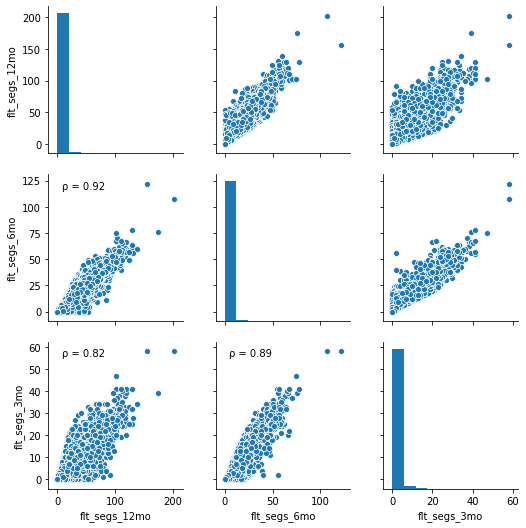

In [20]:
g = sns.pairplot(df_train[['flt_segs_12mo', 'flt_segs_6mo', 'flt_segs_3mo']])
g.map_lower(corrfunc)
plt.show();

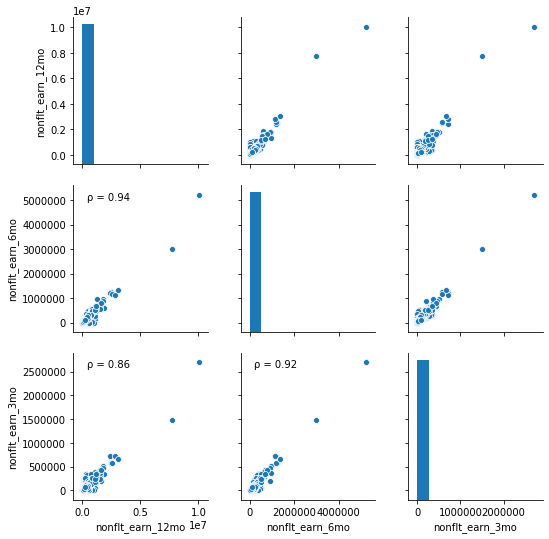

In [21]:
g = sns.pairplot(df_train[['nonflt_earn_12mo', 'nonflt_earn_6mo', 'nonflt_earn_3mo']])
g.map_lower(corrfunc)
plt.show();

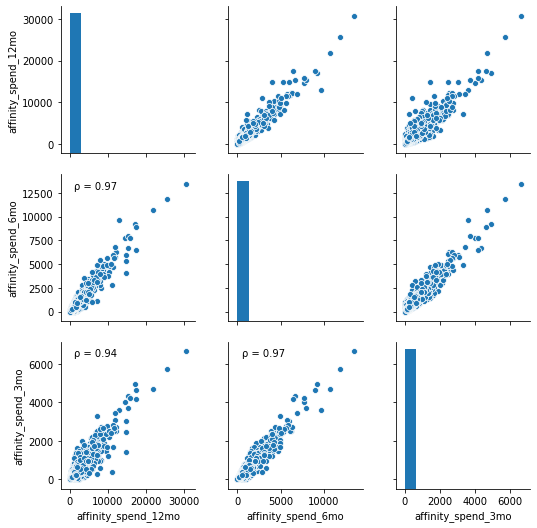

In [22]:
g = sns.pairplot(df_train[['affinity_spend_12mo', 'affinity_spend_6mo', 'affinity_spend_3mo']])
g.map_lower(corrfunc)
plt.show();

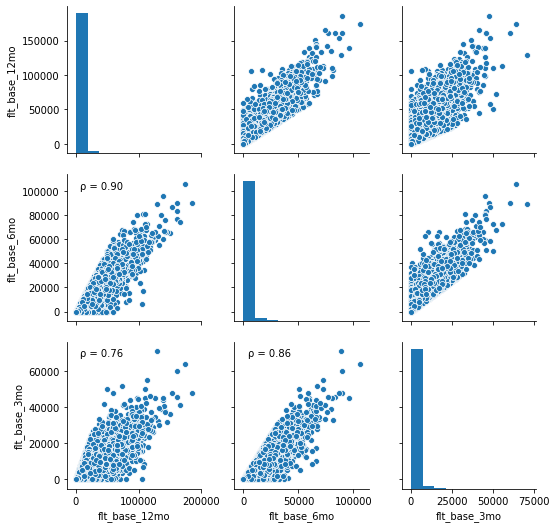

In [46]:
g = sns.pairplot(df_train[['flt_base_12mo', 'flt_base_6mo', 'flt_base_3mo']])
g.map_lower(corrfunc)
plt.show();

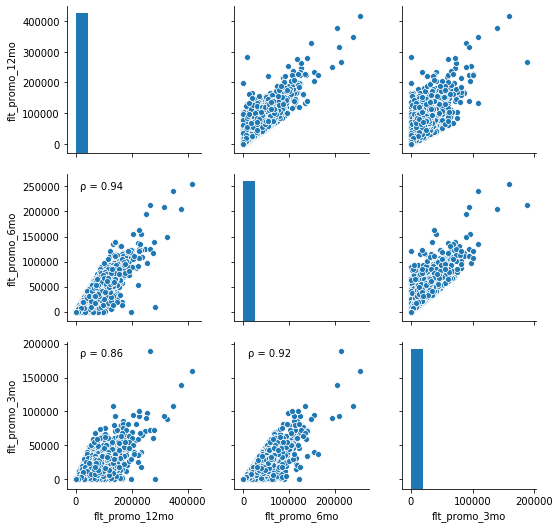

In [47]:
g = sns.pairplot(df_train[['flt_promo_12mo', 'flt_promo_6mo', 'flt_promo_3mo']])
g.map_lower(corrfunc)
plt.show();

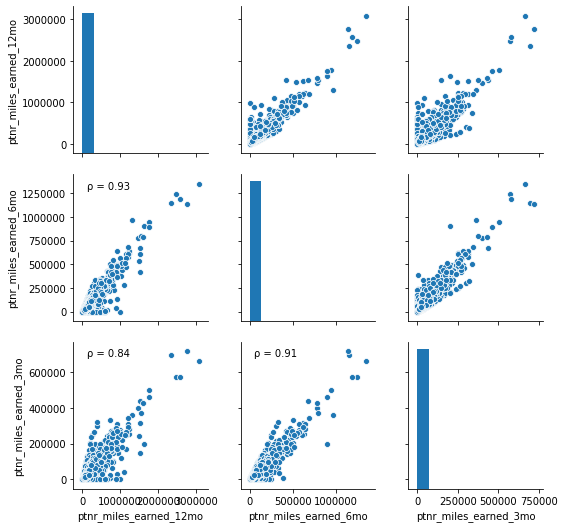

In [48]:
g = sns.pairplot(df_train[['ptnr_miles_earned_12mo', 'ptnr_miles_earned_6mo', 'ptnr_miles_earned_3mo']])
g.map_lower(corrfunc)
plt.show();

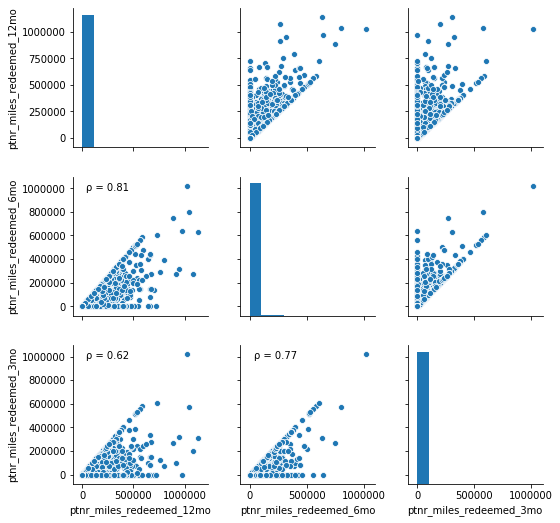

In [49]:
g = sns.pairplot(df_train[['ptnr_miles_redeemed_12mo', 'ptnr_miles_redeemed_6mo', 'ptnr_miles_redeemed_3mo']])
g.map_lower(corrfunc)
plt.show();

The three independent features in each of the above segments are correlated with each other. We will remove and keep one only for each segment before fitting the model.

In [19]:
cols_to_drop = ['nonflt_earn_12mo', 'nonflt_earn_6mo', 'ptnr_miles_redeemed_12mo', 'ptnr_miles_redeemed_6mo', 'ptnr_miles_earned_12mo', 'ptnr_miles_earned_6mo', 'flt_base_6mo', 'flt_base_3mo', 'flt_segs_6mo', 'flt_segs_3mo', 'flt_promo_12mo', 'flt_promo_6mo', 'affinity_spend_12mo', 'affinity_spend_6mo', 'ID']
df_train.drop(cols_to_drop, axis=1, inplace=True)

In [20]:
df_train.corr()['target'].sort_values(ascending=False)

target                     1.000000
nonflt_earn_3mo            0.099359
ptnr_miles_redeemed_3mo    0.061251
awd_use                    0.038638
ptnr_miles_earned_3mo      0.028042
cardholder                 0.025625
aag_yr1                    0.021628
flt_base_12mo              0.021578
flt_segs_12mo              0.020964
affinity_spend_3mo         0.018688
lifetime_aag_base_miles    0.018102
days_flt_enrollment        0.016105
flt_promo_3mo              0.015551
email_subscriber           0.014796
partner_offer_opt_in       0.013461
balance                    0.013275
estatement_opt_in          0.012564
nonflt_use                 0.004429
days_awd_flt              -0.002621
Name: target, dtype: float64

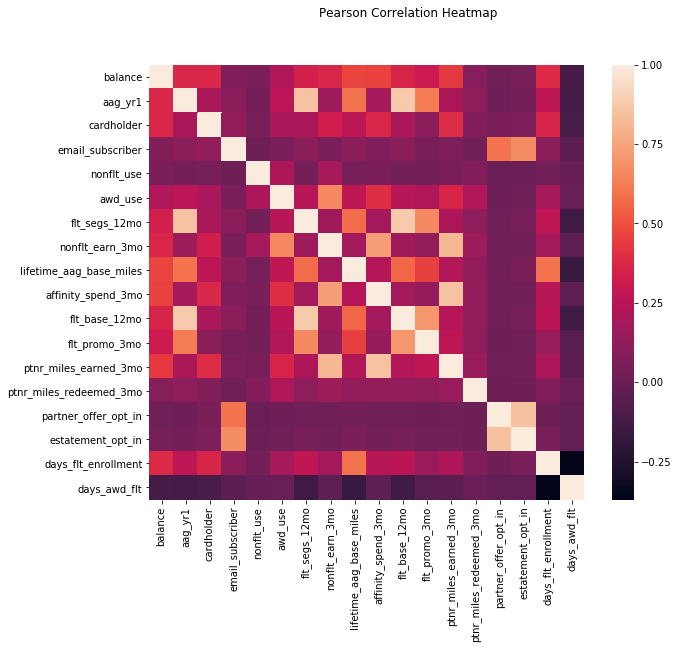

In [21]:
# pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.drop(['target'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

There are still some collinearities. I will remove a few more.

In [22]:
df_train.drop(['estatement_opt_in', 'flt_base_12mo', 'ptnr_miles_earned_3mo', 'flt_segs_12mo'], axis=1, inplace=True)

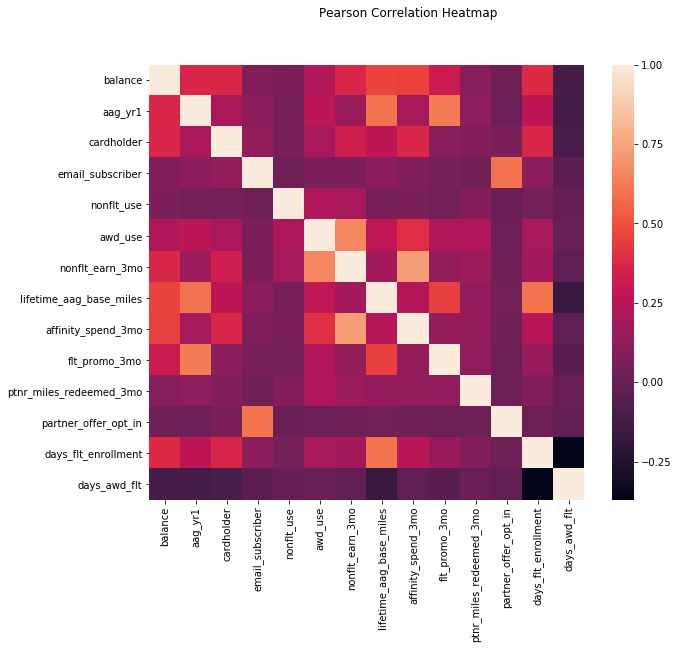

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.drop(['target'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

### Categorical feature

Distribution of categorical feature.

In [24]:
df_train.tier.value_counts()

Regular      483477
Silver        10723
Gold           4387
Platinum       1338
Name: tier, dtype: int64

In [25]:
df_train.describe(include=['O'])

,tier
count,499925
unique,4
top,Regular
freq,483477


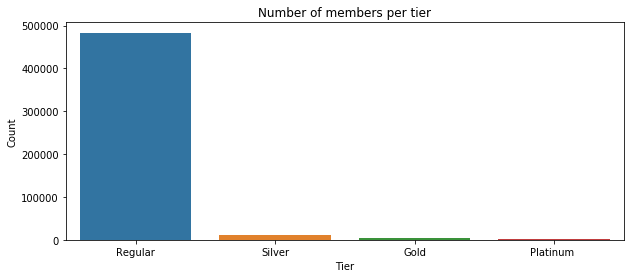

In [26]:
plt.figure(figsize=(10,4))
sns.countplot(x="tier", data=df_train, order = df_train['tier'].value_counts().index)
plt.xlabel('Tier')
plt.ylabel('Count')
plt.title('Number of members per tier');

In [27]:
just_dummies = pd.get_dummies(df_train['tier'])
df_train = pd.concat([df_train, just_dummies], axis=1)      
df_train.drop('tier', inplace=True, axis=1)

Nomalize the data and train test split

In [28]:
X = df_train.drop('target', axis=1)
y = df_train.target
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

### Modelding

A bagging classifier with additional balancing.

In [29]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),                                
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

In [30]:
y_pred = bbc.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[130365  19388]
 [    60    165]]


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    149753
           1       0.01      0.73      0.02       225

    accuracy                           0.87    149978
   macro avg       0.50      0.80      0.47    149978
weighted avg       1.00      0.87      0.93    149978



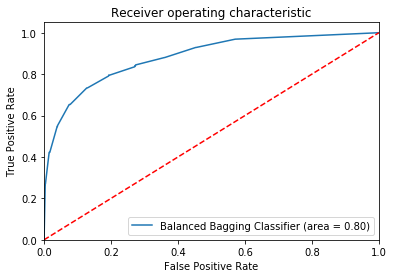

In [32]:
bbc_roc_auc = roc_auc_score(y_test, bbc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bbc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Balanced Bagging Classifier (area = %0.2f)' % bbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show();

A balanced random forest classifier

In [33]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=0,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [34]:
y_pred = brf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[114101  35652]
 [    38    187]]


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    149753
           1       0.01      0.83      0.01       225

    accuracy                           0.76    149978
   macro avg       0.50      0.80      0.44    149978
weighted avg       1.00      0.76      0.86    149978



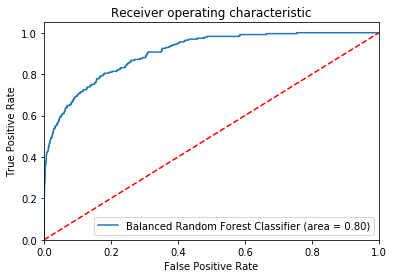

In [37]:
brf_roc_auc = roc_auc_score(y_test, brf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, brf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Balanced Random Forest Classifier (area = %0.2f)' % brf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show();

I decided Balanced Random Forest Classifier will be my final model, simply because it has a little higher recall on 1. And I am using this model to predict and assign propensity score for the members in score data set.

In [46]:
import pickle

filename = 'propensity_model.sav'
pickle.dump(brf, open(filename, 'wb'))

Load the score data and sanity check whether there are same member in both training and score data.

In [38]:
df_score = pd.read_csv('Scoring Data Set.csv')
df_train = pd.read_csv('Training Data Set.csv')
merged_df = pd.merge(df_train, df_score, on=['ID'], how='inner')
merged_df.head()

,balance_x,tier_x,aag_yr1_x,cardholder_x,email_subscriber_x,enrollment_date_x,nonflt_use_x,awd_use_x,most_recent_flt_x,most_recent_awd_x,flt_segs_12mo_x,flt_segs_6mo_x,flt_segs_3mo_x,nonflt_earn_12mo_x,nonflt_earn_6mo_x,nonflt_earn_3mo_x,lifetime_aag_base_miles_x,affinity_spend_12mo_x,affinity_spend_6mo_x,affinity_spend_3mo_x,flt_base_12mo_x,flt_base_6mo_x,flt_base_3mo_x,flt_promo_12mo_x,flt_promo_6mo_x,flt_promo_3mo_x,ptnr_miles_earned_12mo_x,ptnr_miles_earned_6mo_x,ptnr_miles_earned_3mo_x,ptnr_miles_redeemed_12mo_x,ptnr_miles_redeemed_6mo_x,ptnr_miles_redeemed_3mo_x,partner_offer_opt_in_x,estatement_opt_in_x,target,ID,balance_y,tier_y,aag_yr1_y,cardholder_y,email_subscriber_y,enrollment_date_y,nonflt_use_y,awd_use_y,most_recent_flt_y,most_recent_awd_y,flt_segs_12mo_y,flt_segs_6mo_y,flt_segs_3mo_y,nonflt_earn_12mo_y,nonflt_earn_6mo_y,nonflt_earn_3mo_y,lifetime_aag_base_miles_y,affinity_spend_12mo_y,affinity_spend_6mo_y,affinity_spend_3mo_y,flt_base_12mo_y,flt_base_6mo_y,flt_base_3mo_y,flt_promo_12mo_y,flt_promo_6mo_y,flt_promo_3mo_y,ptnr_miles_earned_12mo_y,ptnr_miles_earned_6mo_y,ptnr_miles_earned_3mo_y,ptnr_miles_redeemed_12mo_y,ptnr_miles_redeemed_6mo_y,ptnr_miles_redeemed_3mo_y,partner_offer_opt_in_y,estatement_opt_in_y


Good.

In [39]:
df_result = df_score.copy()

In [40]:
df_score['most_recent_flt'].fillna('2019-10-16', inplace=True)
df_score['most_recent_awd'].fillna('2019-10-16', inplace=True)
df_score['aag_yr1'].fillna(0, inplace=True)

for i in ['enrollment_date', 'most_recent_flt', 'most_recent_awd']:
    df_score[i] = pd.to_datetime(df_score[i])
df_score['enrollment_date'] = df_score['enrollment_date'].dt.date
df_score['most_recent_flt'] = df_score['most_recent_flt'].dt.date
df_score['most_recent_awd'] = df_score['most_recent_awd'].dt.date

for i in ['enrollment_date', 'most_recent_flt', 'most_recent_awd']:
    df_score[i] = pd.to_datetime(df_score[i])
    
df_score['days_flt_enrollment'] = (df_score['most_recent_flt'] - df_score['enrollment_date']).dt.days
df_score['days_awd_flt'] = (df_score['most_recent_awd'] - df_score['most_recent_flt']).dt.days

print(f">> First enrollment day in score data {df_score.enrollment_date.min()}")
print(f">> Last enrollment day in score data {df_score.enrollment_date.max()}")
print()
print(f">> First most recent flight date in score data {df_score.most_recent_flt.min()}")
print(f">> Last most recent flight date in score data {df_score.most_recent_flt.max()}")
print()
print(f">> First most recent award date in score data {df_score.most_recent_awd.min()}")
print(f">> Last most recent award date in score data {df_score.most_recent_awd.max()}")

df_score.drop(['enrollment_date', 'most_recent_flt', 'most_recent_awd'], axis=1, inplace=True)

>> First enrollment day in score data 1935-02-26 00:00:00
>> Last enrollment day in score data 2019-04-30 00:00:00

>> First most recent flight date in score data 2005-06-08 00:00:00
>> Last most recent flight date in score data 2019-10-16 00:00:00

>> First most recent award date in score data 2005-11-23 00:00:00
>> Last most recent award date in score data 2019-10-16 00:00:00


In [41]:
cols_to_drop = ['nonflt_earn_12mo', 'nonflt_earn_6mo', 'ptnr_miles_redeemed_12mo', 'ptnr_miles_redeemed_6mo', 'ptnr_miles_earned_12mo', 'ptnr_miles_earned_6mo', 'flt_base_6mo', 'flt_base_3mo', 'flt_segs_6mo', 'flt_segs_3mo', 'flt_promo_12mo', 'flt_promo_6mo', 'affinity_spend_12mo', 'affinity_spend_6mo', 'estatement_opt_in', 'flt_base_12mo', 'ptnr_miles_earned_3mo', 'flt_segs_12mo']
df_score.drop(cols_to_drop, axis=1, inplace=True)

just_dummies = pd.get_dummies(df_score['tier'])

df_score = pd.concat([df_score, just_dummies], axis=1)      
df_score.drop('tier', inplace=True, axis=1)

In [42]:
df_score = df_score.drop(['ID'], axis=1)
df_score = scaler.transform(df_score)
df_result['propensity'] = brf.predict_proba(df_score)[:,1]

In [43]:
df_result.sort_values(by=['propensity'], ascending=False)

,balance,tier,aag_yr1,cardholder,email_subscriber,enrollment_date,nonflt_use,awd_use,most_recent_flt,most_recent_awd,flt_segs_12mo,flt_segs_6mo,flt_segs_3mo,nonflt_earn_12mo,nonflt_earn_6mo,nonflt_earn_3mo,lifetime_aag_base_miles,affinity_spend_12mo,affinity_spend_6mo,affinity_spend_3mo,flt_base_12mo,flt_base_6mo,flt_base_3mo,flt_promo_12mo,flt_promo_6mo,flt_promo_3mo,ptnr_miles_earned_12mo,ptnr_miles_earned_6mo,ptnr_miles_earned_3mo,ptnr_miles_redeemed_12mo,ptnr_miles_redeemed_6mo,ptnr_miles_redeemed_3mo,partner_offer_opt_in,estatement_opt_in,ID,propensity
45488,844,Regular,0.0,False,False,2016-12-18T05:00:00.000Z,0,160000,NaN,2019-03-20 00:00:00,0,0,0,145433,90433,90433,0,0.0,0.0,0.0,0,0,0,0,0,0,144433,89433,89433,160000,160000,160000,False,False,327884,1.000000
97760,98512,Regular,0.0,False,True,2018-03-31T04:00:00.000Z,0,125000,NaN,2019-04-29 00:00:00,0,0,0,223512,223400,64400,0,0.0,0.0,0.0,0,0,0,0,0,0,75000,75000,0,125000,125000,100000,True,True,398273,1.000000
99338,220500,Regular,0.0,False,True,2019-04-19T04:00:00.000Z,0,0,NaN,NaN,0,0,0,220500,220500,220500,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,True,True,523458,0.993830
11718,600,Regular,0.0,False,True,2017-09-16T04:00:00.000Z,0,75000,NaN,2019-02-14 00:00:00,0,0,0,75600,75600,75600,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,75000,75000,75000,True,True,257025,0.992500
50856,15501,Regular,0.0,False,True,2016-12-26T05:00:00.000Z,0,207500,NaN,2019-03-13 00:00:00,0,0,0,108000,105000,90000,0,0.0,0.0,0.0,0,0,0,0,0,0,90000,90000,90000,207500,150000,150000,True,True,173059,0.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27364,2894,Regular,2894.0,False,False,2018-01-13T05:00:00.000Z,0,0,2018-02-02 00:00:00,NaN,0,0,0,0,0,0,2894,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,370707,0.008774
37494,6902,Regular,0.0,False,False,2015-12-09T05:00:00.000Z,0,0,2017-08-23 00:00:00,NaN,0,0,0,0,0,0,4402,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,131828,0.008246
29231,4433,Regular,933.0,False,False,2016-09-15T04:00:00.000Z,0,0,2018-05-12 00:00:00,NaN,1,0,0,0,0,0,4433,0.0,0.0,0.0,933,0,0,0,0,0,0,0,0,0,0,0,False,False,162197,0.008246
37620,7015,Regular,0.0,False,False,2016-04-30T04:00:00.000Z,0,0,2019-02-08 00:00:00,NaN,3,3,3,1,1,0,7014,0.0,0.0,0.0,1873,1873,1873,187,187,187,0,0,0,0,0,0,False,False,147323,0.007427


In [44]:
df_result.sort_values(by=['propensity'], ascending=False)[['ID', 'propensity']]

,ID,propensity
45488,327884,1.000000
97760,398273,1.000000
99338,523458,0.993830
11718,257025,0.992500
50856,173059,0.990000
...,...,...
27364,370707,0.008774
37494,131828,0.008246
29231,162197,0.008246
37620,147323,0.007427


In [45]:
df_result.sort_values(by=['propensity'], ascending=False)[['ID', 'propensity']].to_csv('propensity_score_result.csv', index=False)

### Feature importance techniques

Using False Positive Rate test

In [47]:
pd.options.display.float_format = '{:.4f}'.format
fpr= SelectFpr(chi2, alpha=0.001)
fpr = fpr.fit(X_train,y_train)
fpr_df=pd.DataFrame({'p_val':fpr.pvalues_,'features':X.columns.tolist()})
fpr_df.sort_values('p_val',ascending=True)

,p_val,features
10,0.0000,ptnr_miles_redeemed_3mo
2,0.0000,cardholder
17,0.0000,Silver
6,0.0000,nonflt_earn_3mo
14,0.0000,Gold
11,0.0000,partner_offer_opt_in
3,0.0000,email_subscriber
1,0.0001,aag_yr1
7,0.0006,lifetime_aag_base_miles
9,0.0014,flt_promo_3mo


In [48]:
fpr_df[fpr_df['p_val']<=0.05]

,p_val,features
1,0.0001,aag_yr1
2,0.0000,cardholder
3,0.0000,email_subscriber
5,0.0028,awd_use
6,0.0000,nonflt_earn_3mo
7,0.0006,lifetime_aag_base_miles
8,0.0250,affinity_spend_3mo
9,0.0014,flt_promo_3mo
10,0.0000,ptnr_miles_redeemed_3mo
11,0.0000,partner_offer_opt_in


The end.